In [1]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os 
import copy
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib as mpl
#import collections
import matplotlib.ticker as mticker
from matplotlib import ticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean
import scipy as sp
import warnings
warnings.filterwarnings("ignore")
import os
import eofs.standard as Eof_st
from eofs.multivariate.standard import MultivariateEof

from scipy.signal import butter, lfilter
from scipy.signal import convolve

import importlib


## import dask

In [12]:
print('...setting up dask client...')
if 'client' in locals():
    client.shutdown()
    print('...shutdown client...')
else:
    print('client does not exist yet')

...setting up dask client...
client does not exist yet


In [ ]:
# ### ++++++ dask NCAR client: 
from distributed import Client
from dask_jobqueue import PBSCluster
project_num = 'P03010039' #what project key do you have? 

cluster = PBSCluster(account=project_num,walltime='12:00:00',cores=1, memory='40GB',shared_temp_directory='/glade/derecho/scratch/wchapman/tmp',queue='casper')
cluster.scale(jobs=40)
client = Client(cluster)

## Load Data

In [37]:
dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_meanGPU_exp001/ts/'

filu850 = 'f.e.FTORCHmjo_meanGPU_exp001.cam.h1.U850.anomalies.1979010100000-2010123100000.nc'
var_name_u850 = 'U850'

filu200 = 'f.e.FTORCHmjo_meanGPU_exp001.cam.h1.U200.anomalies.1979010100000-2010123100000.nc' 
var_name_u200 = 'U200'

filv200 = 'f.e.FTORCHmjo_meanGPU_exp001.cam.h1.V200.anomalies.1979010100000-2010123100000.nc'
var_name_V200 = 'V200'

filv850 = 'f.e.FTORCHmjo_meanGPU_exp001.cam.h1.V850.anomalies.1979010100000-2010123100000.nc'
var_name_v850 = 'V850'

phases_in = 'f.e.FTORCHmjo_meanGPU_exp001.cam.h1.MJO_EOFS_FLUT_U200_U850.nc'

filv_inc = 'f.e.FTORCHmjo_meanGPU_exp001.cam.h1.cb24cnn_V.1979010100000-2010123100000.nc'

filu_inc = 'f.e.FTORCHmjo_meanGPU_exp001.cam.h1.cb24cnn_U.1979010100000-2010123100000.nc'

###########################################################################
######################### Templates #######################################
###########################################################################
dir_out = f'{dir_in}/mjo_diag/'
# Check if the directory exists
if not os.path.exists(dir_out):
    # Create the directory
    os.makedirs(dir_out)
    print(f"Directory {dir_out} created.")

In [4]:
import xarray as xr

In [5]:
xr.open_dataset('/glade/campaign/cgd/amp/wchapman/archive/f.e.FTORCHmjo_CNNmjo_tot/atm/hist/f.e.FTORCHmjo_CNNmjo_tot.cam.h1.1979-03-22-00000.nc')

<xarray.Dataset>
Dimensions:       (lat: 192, lon: 288, lev: 32, ilev: 33, time: 10, nbnd: 2,
                   nprob: 9)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 1979-03-22 00:00:00 ... 1979-03-31 00:00:00
Dimensions without coordinates: nbnd, nprob
Data variables: (12/48)
    gw            (lat) float64 ...
    hyam          (lev) float64 ...
    hybm          (lev) float64 ...
    P0            float64 ...
    hyai          (ilev) float64 ...
    hybi          (ilev) float64 ...
    ...            ...
    V850          (time, lat, lon) float64 ...
    VBOT          (time, lat, lon) float64 ...
    Z500          (time, lat, lon) float64 ...
    cb24mjocnn_U  (time, lev, lat, lon) float64 ...
    cb24mjocnn_V  (time, lev, lat, lon) float64 ...
    state_mjo     (time, nprob, lat, lon) float64 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              f.e.FTORCHmjo_CNNmjo_tot
    logname:           wchapman
    host:              derecho7
    initial_file:      f.e20.FHIST.f09_f09.cesm2_1.001_v2.cam.i.1979-01-01-00...
    topography_file:   /glade/campaign/cesm/cesmdata/inputdata/atm/cam/topo/f...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  day_1

## What level?

In [73]:
LevDo = 1000

## Data in

In [74]:
# u200: 
file_path_u200 = os.path.join(dir_in, filu200)  # Join the directory and file name
DS_u200 = xr.open_dataset(file_path_u200)

# u850: 
file_path_u850 = os.path.join(dir_in, filu850)  # Join the directory and file name
DS_u850 = xr.open_dataset(file_path_u850)

# v850: 
file_path_v850 = os.path.join(dir_in, filv850)  # Join the directory and file name
DS_v850 = xr.open_dataset(file_path_v850)

# v850: 
file_path_v200 = os.path.join(dir_in, filv200)  # Join the directory and file name
DS_v200 = xr.open_dataset(file_path_v200)

# DS_phases
file_path_phases = os.path.join(dir_out, phases_in)  # Join the directory and file name
DS_phases = xr.open_dataset(file_path_phases)


file_path_uinc = os.path.join(dir_in, filu_inc)  # Join the directory and file name
DS_uInc = xr.open_dataset(file_path_uinc).sel(lev=LevDo, method='nearest').squeeze()

file_path_vinc = os.path.join(dir_in, filv_inc)  # Join the directory and file name
DS_vInc = xr.open_dataset(file_path_vinc).sel(lev=LevDo, method='nearest').squeeze()

#create cosine latitude weighting: 
weights = np.cos(np.deg2rad(DS_u200.lat))

## Select Winter

In [75]:
%%time
NDFJMA_u200 = DS_u200.where((DS_u200['time.month'] >= 11) | (DS_u200['time.month'] <= 5), drop=True)
NDFJMA_u850 = DS_u850.where((DS_u850['time.month'] >= 11) | (DS_u850['time.month'] <= 5), drop=True)
NDFJMA_v200 = DS_v200.where((DS_v200['time.month'] >= 11) | (DS_v200['time.month'] <= 5), drop=True)
NDFJMA_v850 = DS_v850.where((DS_v850['time.month'] >= 11) | (DS_v850['time.month'] <= 5), drop=True)
NDFJMA_vInc = DS_vInc.where((DS_vInc['time.month'] >= 11) | (DS_vInc['time.month'] <= 5), drop=True)
NDFJMA_uInc = DS_uInc.where((DS_uInc['time.month'] >= 11) | (DS_uInc['time.month'] <= 5), drop=True)
NDFJMA_phases = DS_phases.where((DS_phases['time.month'] >= 11) | (DS_phases['time.month'] <= 5), drop=True)

CPU times: user 11.7 s, sys: 1min 34s, total: 1min 46s
Wall time: 4min 4s


## Composite by phase Increment

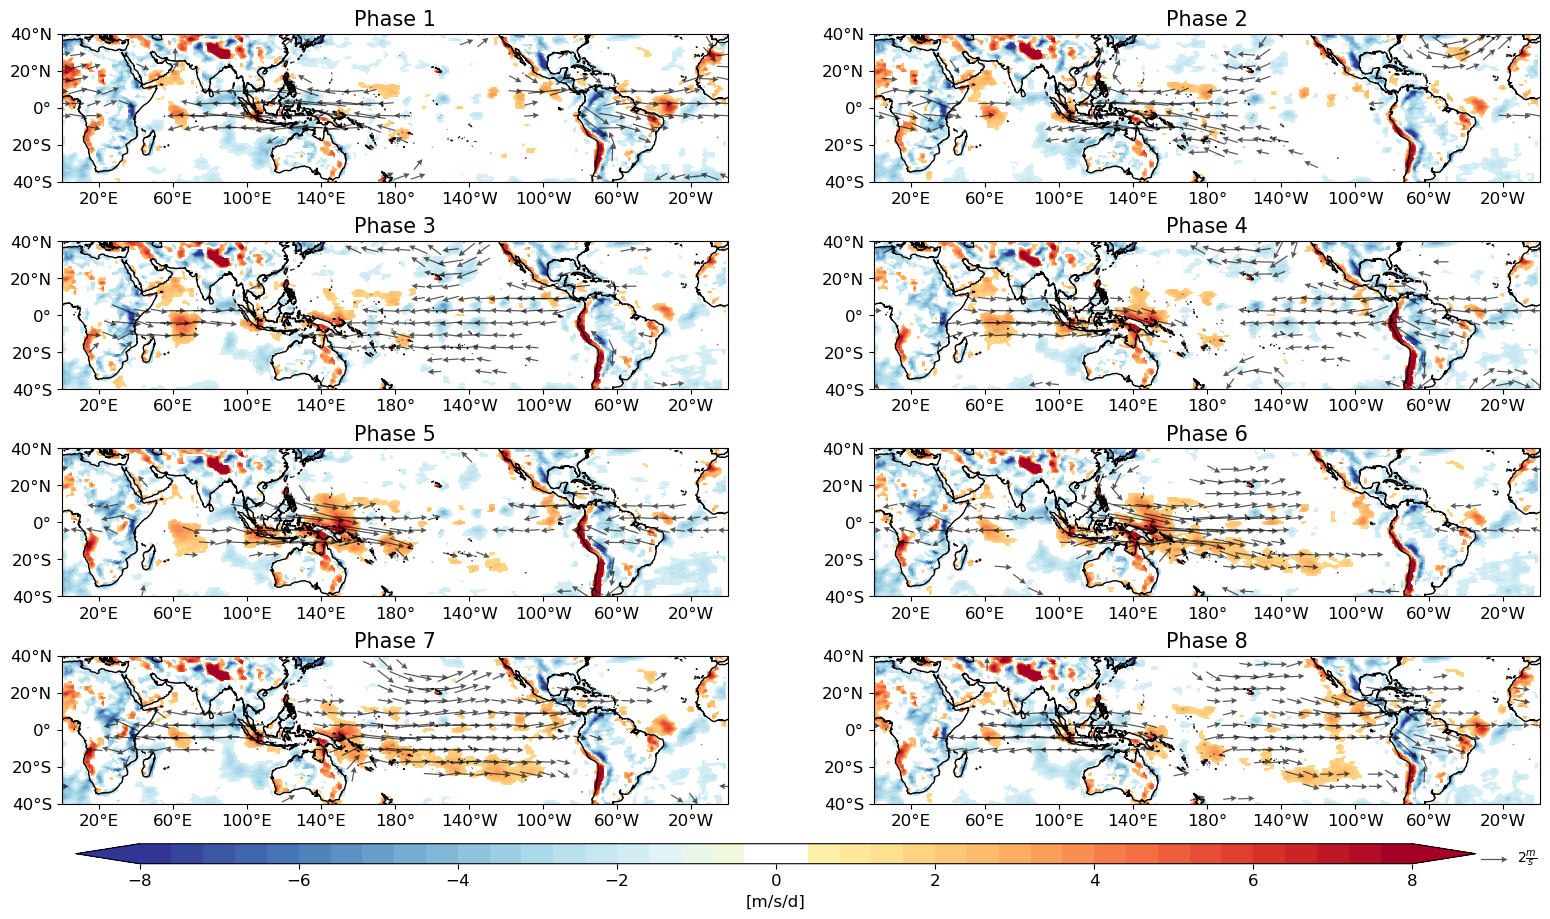

In [79]:
# Setup remains largely the same
# Define clevs and colormap for your data here
# Parameters and data setup (remains the same)
clevs = np.arange(-8, 8.4, .4)
bluey = mpl.cm.get_cmap('RdYlBu_r', len(clevs))
newcolors = bluey(np.linspace(0, 1, len(clevs)))
nnn = int(np.floor(newcolors.shape[0]/2))
newcolors[nnn] = newcolors[nnn]/newcolors[nnn]
newcolors[nnn+1] = newcolors[nnn+1]/newcolors[nnn+1]
newcolors[nnn-1] = newcolors[nnn-1]/newcolors[nnn-1]
cmapzzz = ListedColormap(newcolors)

#begin fig
fig = plt.figure(figsize=(20, 10))  # Adjusted figure size for 8 panels
proj = ccrs.PlateCarree(central_longitude=180)

lvlv = 1000

for phs in range(1,9):
    inds = np.where(NDFJMA_phases['RMMphase_obs']==phs)[0]
    
    ax = plt.subplot(4, 2, phs, projection=proj)  # Dynamic subplot creation
    ax.coastlines('50m')

    u = (NDFJMA_u850[var_name_u850].isel(time=inds)).mean('time')
    v = (NDFJMA_v850[var_name_v850].isel(time=inds)).mean('time')

    # Apply the mask: Replace vectors with small magnitudes with NaNs
    mask = np.sqrt(u**2 + v**2) < 1
    u = np.where(mask, np.nan, u)
    v = np.where(mask, np.nan, v)

    lon, lat = np.meshgrid(NDFJMA_u850['lon'].values, NDFJMA_u850['lat'].values)

    # Subsampling for quiver plot clarity
    skip = (slice(None, None, 7), slice(None, None, 7))


    pfield = (NDFJMA_uInc['cb24cnn_U'].isel(time=inds)).mean('time')*86400
    sigma_y = .75
    sigma_x = .75
    sigma = [sigma_y, sigma_x]
    y = sp.ndimage.filters.gaussian_filter(pfield, sigma, mode='constant')

    mask2 = np.abs(y) < 1.5 
    y = np.where(mask2, np.nan, y)
    
    lon, lat = np.meshgrid(NDFJMA_u850['lon'].values, NDFJMA_u850['lat'].values)
    # Plotting
    bb = ax.contourf(pfield['lon'] - 180, pfield['lat'], y, levels=clevs, cmap=cmapzzz, transform=proj, extend='both')
    
    q = ax.quiver(lon[skip], lat[skip], u[skip], v[skip],pivot="middle", transform=ccrs.PlateCarree(),
                  color='black', scale=50, alpha=0.66,linewidths=0.01, width=0.0018,headwidth=5)

    if phs == 8:
        qk = ax.quiverkey(q, 0.95, -.37, 2, r'$2 \frac{m}{s}$', labelpos='E',
                       transform=ax.transAxes, color='black')
        
    # Set ticks, labels, and title dynamically
    ax.set_xticks([20, 60, 100, 140, 180, 220, 260, 300, 340], crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-60, 70, 20), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True, number_format='.0f'))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.tick_params(labelsize=12)
    ax.set_extent([0, 360, -40, 40], crs=ccrs.PlateCarree())
    ax.set_title(f'Phase {phs}', fontsize=15)  # Dynamic title

    
# Add a colorbar at the bottom of the figure
# Use the axes_list for positioning
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height] in figure coordinate
cbar=fig.colorbar(bb, cax=cbar_ax, orientation='horizontal', label='[m/s/d]')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='[m/s/d]',fontsize=12)
fig.subplots_adjust(hspace=0.4,wspace=0.1)  # Adjust spacing as needed
plt.savefig(f'./quiver_composite_nudging_U_lev{LevDo}.png',bbox_inches='tight',dpi=400)
plt.show()

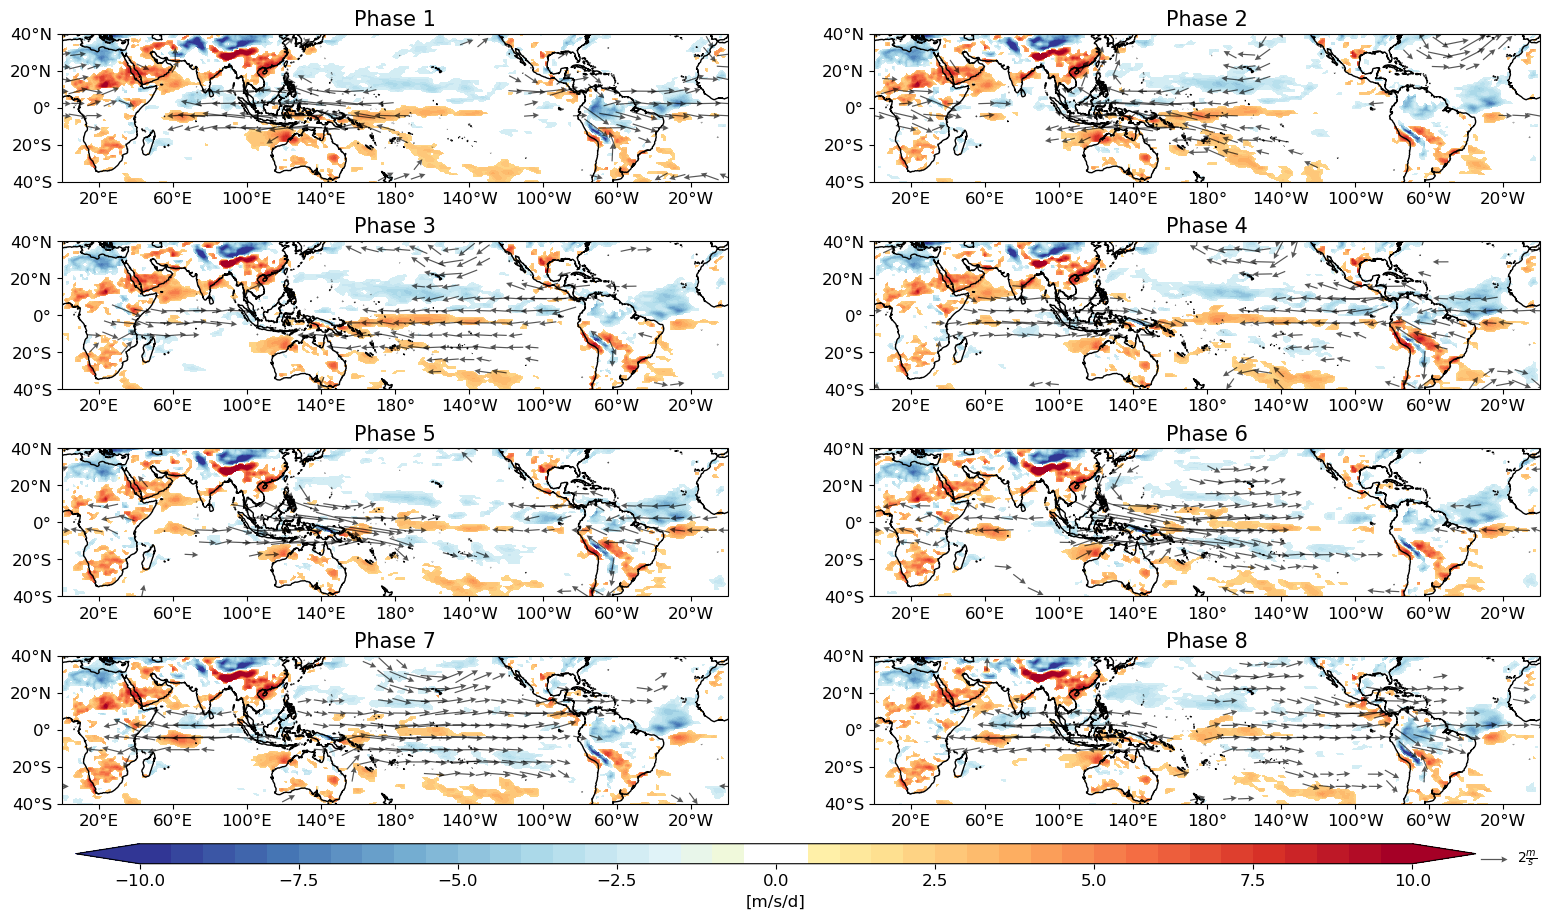

In [77]:
# Setup remains largely the same
# Define clevs and colormap for your data here
# Parameters and data setup (remains the same)
clevs = np.arange(-10, 10.5, .5)
bluey = mpl.cm.get_cmap('RdYlBu_r', len(clevs))
newcolors = bluey(np.linspace(0, 1, len(clevs)))
nnn = int(np.floor(newcolors.shape[0]/2))
newcolors[nnn] = newcolors[nnn]/newcolors[nnn]
newcolors[nnn+1] = newcolors[nnn+1]/newcolors[nnn+1]
newcolors[nnn-1] = newcolors[nnn-1]/newcolors[nnn-1]
cmapzzz = ListedColormap(newcolors)

#begin fig
fig = plt.figure(figsize=(20, 10))  # Adjusted figure size for 8 panels
proj = ccrs.PlateCarree(central_longitude=180)

lvlv = 1000

for phs in range(1,9):
    inds = np.where(NDFJMA_phases['RMMphase_obs']==phs)[0]
    
    ax = plt.subplot(4, 2, phs, projection=proj)  # Dynamic subplot creation
    ax.coastlines('50m')

    u = (NDFJMA_u850[var_name_u850].isel(time=inds)).mean('time')
    v = (NDFJMA_v850[var_name_v850].isel(time=inds)).mean('time')

    # Apply the mask: Replace vectors with small magnitudes with NaNs
    mask = np.sqrt(u**2 + v**2) < 1
    u = np.where(mask, np.nan, u)
    v = np.where(mask, np.nan, v)

    lon, lat = np.meshgrid(NDFJMA_u850['lon'].values, NDFJMA_u850['lat'].values)

    # Subsampling for quiver plot clarity
    skip = (slice(None, None, 7), slice(None, None, 7))


    pfield = (NDFJMA_vInc['cb24cnn_V'].isel(time=inds)).mean('time')*86400
    sigma_y = .75
    sigma_x = .75
    sigma = [sigma_y, sigma_x]
    y = sp.ndimage.filters.gaussian_filter(pfield, sigma, mode='constant')
    mask2 = np.abs(y) < 1.5
    y = np.where(mask2, np.nan, y)
    
    lon, lat = np.meshgrid(NDFJMA_u850['lon'].values, NDFJMA_u850['lat'].values)
    # Plotting
    bb = ax.contourf(pfield['lon'] - 180, pfield['lat'], y, levels=clevs, cmap=cmapzzz, transform=proj, extend='both')
    
    q = ax.quiver(lon[skip], lat[skip], u[skip], v[skip],pivot="middle", transform=ccrs.PlateCarree(),
                  color='black', scale=50, alpha=0.66,linewidths=0.01, width=0.0018,headwidth=5)

    if phs == 8:
        qk = ax.quiverkey(q, 0.95, -.37, 2, r'$2 \frac{m}{s}$', labelpos='E',
                       transform=ax.transAxes, color='black')
        
    # Set ticks, labels, and title dynamically
    ax.set_xticks([20, 60, 100, 140, 180, 220, 260, 300, 340], crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-60, 70, 20), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True, number_format='.0f'))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.tick_params(labelsize=12)
    ax.set_extent([0, 360, -40, 40], crs=ccrs.PlateCarree())
    ax.set_title(f'Phase {phs}', fontsize=15)  # Dynamic title

    
# Add a colorbar at the bottom of the figure
# Use the axes_list for positioning
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height] in figure coordinate
cbar=fig.colorbar(bb, cax=cbar_ax, orientation='horizontal', label='[m/s/d]')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='[m/s/d]',fontsize=12)
fig.subplots_adjust(hspace=0.4,wspace=0.1)  # Adjust spacing as needed
plt.savefig(f'./quiver_composite_nudging_V_lev{LevDo}.png',bbox_inches='tight',dpi=400)
plt.show()

In [27]:
import matplotlib.pyplot as pl
import numpy as np
import scipy as sp
import scipy.ndimage

n = 200 # widht/height of the array
m = 1000 # number of points
sigma_y = 1.0
sigma_x = 1.0

# Create input array
x = np.zeros((n, n)) 
i = np.random.choice(range(0, n * n), size=m)
x[i / n, i % n] = 1.0

# Plot input array
pl.imshow(x, cmap='Blues', interpolation='nearest')
pl.xlabel("$x$")
pl.ylabel("$y$")
pl.savefig("array.png")

# Apply gaussian filter
sigma = [sigma_y, sigma_x]
y = sp.ndimage.filters.gaussian_filter(x, sigma, mode='constant')

# Display filtered array
pl.imshow(y, cmap='Blues', interpolation='nearest')
pl.xlabel("$x$")
pl.ylabel("$y$")
pl.title("$\sigma_x = " + str(sigma_x) + "\quad \sigma_y = " + str(sigma_y) + "$")
pl.savefig("smooth_array_" + str(sigma_x) + "_" + str(sigma_y) + ".png")

IndexError: arrays used as indices must be of integer (or boolean) type